In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import spectrogram, stft, istft, check_NOLA
from sklearn.linear_model import LinearRegression

plt.style.use('ggplot')

# UTILITY FUNCTIONS

In [2]:
subsampleFreq = 64   # FINAL FREQUENCY IN HERTZ AFTER SUBSAMPLING
secondsInWindow = 1.
nperseg = subsampleFreq * secondsInWindow
noverlap = nperseg - 1
window = ('tukey', .25)

In [3]:
# CONVERT STFT FROM R,THETA TO COMPLEX
# dim(z) = (# timesteps, # freq bins x 2 (2 reals = 1 complex))

def rThetaToComplex(z):
    rows, cols = z.shape
    shortTermFourier = np.zeros((rows, cols // 2), dtype=np.csingle)
    for i in range(rows):
        for k in range(cols // 2):
            r = z[i,k]
            theta = z[i, (k + cols // 2)]
            shortTermFourier[i,k] =  r * np.exp(complex(0, theta))
    return shortTermFourier.transpose() # dim = (# freq bins, # timepoints)

# CONVERT REAL STFT TO COMPLEX STFT, INVERT TO GET THE ISTFT (I.E. TIME SERIES), THEN PLOT

def realSTFTtoTimeSeries(realSTFT):
    shortTermFourierComplex = rThetaToComplex(realSTFT)
    times, inverseShortFourier = istft(shortTermFourierComplex, 
                                       fs=subsampleFreq, 
                                       window=window, 
                                       nperseg=nperseg, 
                                       noverlap=noverlap)
    return times, inverseShortFourier

# LOAD NUMPY ARRAYS

In [4]:
arraySavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/trainTestRTheta.npz'
npzfile = np.load(arraySavePath)
x_trainRTheta = npzfile['x_trainRTheta']
x_validRTheta = npzfile['x_validRTheta'] 
y_trainRTheta = npzfile['y_trainRTheta'] 
y_validRTheta = npzfile['y_validRTheta']

_,nY = y_validRTheta.shape

# MULTI-OUTPUT LINEAR REGRESSION

In [5]:
lreg = LinearRegression().fit(x_trainRTheta, y_trainRTheta)

# Plot results of fit

<IPython.core.display.Javascript object>


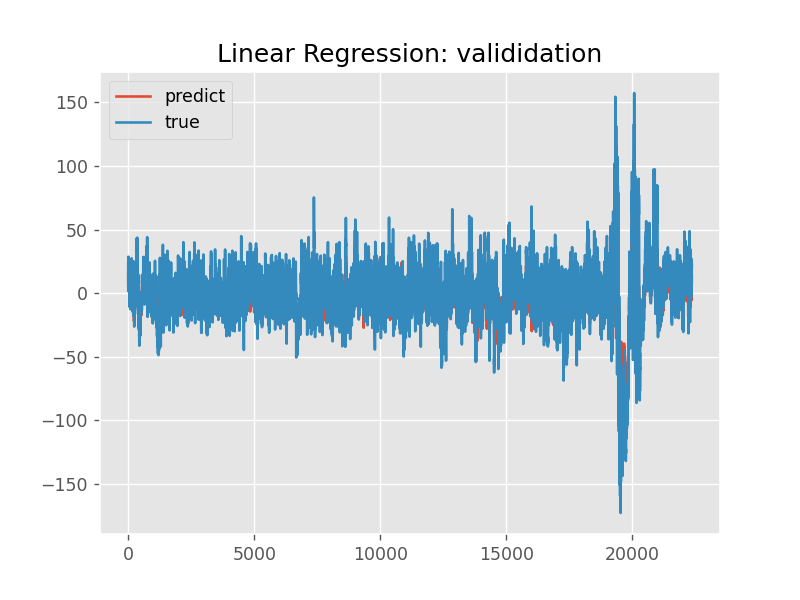

In [6]:
# PLOT PREDICTION VERSUS TRUTH

trainPlotFlag = False
    
if trainPlotFlag:
    x = x_trainRTheta
    y = y_trainRTheta
    trainTitle = 'train'
else:
    x = x_validRTheta
    y = y_validRTheta
    trainTitle = 'valididation'
    
freqPredict = lreg.predict(x)
title = 'Linear Regression: ' + trainTitle

_, yPred = realSTFTtoTimeSeries(freqPredict)
_, yTrue = realSTFTtoTimeSeries(y)

plt.figure()
plt.plot(yPred, label='predict')
plt.plot(yTrue, label='true')
plt.legend()
plt.title(title)
plt.show()